In [ ]:
api_key =   #replace it with openAI api key

# Provide the folder ID from the Google Drive link where item embeddings are loaded
folder_id = '18Ryk87NyHuGydGvhNYgBG3d0bpbBX8r_'
load_trained_data = 1
run_openAI_experiments = 1-load_trained_data

In [ ]:
!pip install openai==0.28.0
!pip install faiss-cpu
# Install PyDrive
!pip install -U -q PyDrive
import openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.2
    Uninstalling openai-1.52.2:
      Successfully uninstalled openai-1.52.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 26.9 MB/s eta 0:00:00


## Utility Functions

In [ ]:
import numpy as np
import pandas as pd
def print_statistics(data):
    total_interactions = data.shape[0]
    unique_users = data['userId'].nunique()
    unique_items = data['itemId'].nunique()

    print("--------------------------")
    print("The Dataset Overview:")
    print(f" - Total Interactions: {total_interactions}")
    print(f" - |U|: {unique_users}")
    print(f" - |I|: {unique_items}")
    print(f" - |R|/|U|: {total_interactions / unique_users:.2f}")
    print(f" - |R|/|I|: {total_interactions / unique_items:.2f}")
    print(f" - |R|/(|U|*|I|): {total_interactions / (unique_users * unique_items):.10f}")
    print("--------------------------")
# print_statistics(train_df)
# print_statistics(test_df)


def sample_users(df_ratings, num_users):
    # Get a list of unique users
    unique_users = df_ratings['userId'].unique()

    # Sample a specified number of users
    sampled_users = pd.Series(unique_users).sample(n=num_users, random_state=42)

    # Get all ratings for the sampled users
    df_sampled_ratings = df_ratings[df_ratings['userId'].isin(sampled_users)]

    return df_sampled_ratings


def apply_interaction_limits(data, min_interactions, max_interactions, user_col, item_col):
    # Count the number of interactions by user
    interaction_counts = data[user_col].value_counts()

    # Filter out users outside the interaction limits
    users_to_keep = interaction_counts[(interaction_counts >= min_interactions) & (interaction_counts <= max_interactions)].index
    return data[data[user_col].isin(users_to_keep)]


def analyze_tags(df_item):
    # Count unique item IDs
    unique_item_ids = df_item['itemId'].nunique()

    # Count unique tags across all items (flattening the lists first)
    unique_tags = set(tag for sublist in df_item['tag'] for tag in sublist)
    unique_tags_count = len(unique_tags)

    # Count how many items have at least one tag
    items_with_tags = df_item[df_item['tag'].apply(lambda tags: len(tags) > 0)].shape[0]

    # Count how many items have no tags
    total_items = df_item.shape[0]
    items_without_tags = total_items - items_with_tags

    # Normalize to the entire number of items to get percentages
    items_with_tags_percentage = (items_with_tags / total_items) * 100
    items_without_tags_percentage = (items_without_tags / total_items) * 100

    # Print the results
    print(f"Total unique items (itemId): {unique_item_ids}")
    print(f"Total unique tags: {unique_tags_count}")
    print(f"Items with at least one tag: {items_with_tags} ({items_with_tags_percentage:.2f}%)")
    print(f"Items with no tags: {items_without_tags} ({items_without_tags_percentage:.2f}%)")


def check_column_for_nan(df, column_name):
    """
    Checks if a column in a DataFrame, identified by its name, contains NaN values.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.
    column_name (str): The name of the column to check for NaN values.

    Returns:
    int: 1 if NaN values are found, 0 if no NaN values are present.
    """
    # Ensure the column_name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Return 1 if NaN values are found, otherwise return 0
    return int(df[column_name].isna().any())


# Introduce a NaN value in the 'tags' column
data = {
    'title': ['Movie A', 'Movie B', 'Movie C'],
    'genres': ['Action', 'Drama', 'Comedy'],
    'tags': ['Tag1', np.nan, 'Tag3']  # Introducing NaN in the 'tags' column
}

df = pd.DataFrame(data)
display(df)
# Check if the 'tags' column has NaN values
result = check_column_for_nan(df, 'tags')
print(f"'tags' column has NaN values: {result}")

# Check if the 'title' column has NaN values
result = check_column_for_nan(df, 'title')
print(f"'title' column has NaN values: {result}")


,title,genres,tags
0,Movie A,Action,Tag1
1,Movie B,Drama,NaN
2,Movie C,Comedy,Tag3


'tags' column has NaN values: 1
'title' column has NaN values: 0


In [ ]:
import requests
import pandas as pd

def download_csv(url, csv_file_name):
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(csv_file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"{csv_file_name} downloaded successfully.")
        return True
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
        return False

def load_datasets():
    # URLs for the ratings, items, and users datasets
    urlRatings = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_ratings_ml-latest-small.csv"
    urlItems = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_item_ml-latest-small.csv"
    urlTags = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/21484da12f01263fc0194d12c63d796628f84137/ml_latest/df_tags_ml-latest-small.csv"

    # Local filenames
    ratings_file = "df_ratings_ml-latest-small.csv"
    items_file = "df_item_ml-latest-small.csv"
    tags_file = "df_tags_ml-latest-small.csv"

    # Download the ratings, items, and users files
    if download_csv(urlRatings, ratings_file) and download_csv(urlItems, items_file) and download_csv(urlTags, tags_file):
        column_name = ['userId', 'itemId', 'rating', 'timestamp']
        df_ratings = pd.read_csv(ratings_file, sep=',', low_memory=False, header= 0 , names=column_name)
        df_items = pd.read_csv(items_file, sep=',', low_memory=False)
        df_tags = pd.read_csv(tags_file, sep=',', low_memory=False)
        df_ratings['userId'] = df_ratings['userId'].astype(int)
        df_ratings['itemId'] = df_ratings['itemId'].astype(int)
        df_items['itemId'] = df_items['itemId'].astype(int)
        df_tags['itemId'] = df_tags['itemId'].astype(int)
        df_tags['userId'] = df_tags['userId'].astype(int)

        # Group the tags by itemId and aggregate them into a list
        tags_grouped = df_tags.groupby('itemId')['tag'].apply(list).reset_index()

        # Merge the tags with the df_item to create a new column 'tags'
        df_items_merged = pd.merge(df_items, tags_grouped, on='itemId', how='left')

        # If there are items without tags, they will have NaN in the 'tags' column; replace with an empty list
        df_items_merged['tag'] = df_items_merged['tag'].apply(lambda x: x if isinstance(x, list) else [])

        print("ml-latest-small Datasets and tags loaded successfully.")
        print("Datasets loaded successfully.")
        return df_ratings, df_items,  df_tags, df_items_merged
    else:
        print("Failed to download one or more datasets.")
        return None, None, None

DS_name = "ml-latest-small"
# Usage example for ml-latest-small ratings, items, and users datasets
df_ratings, df_items, df_tags, df_items_merged = load_datasets()

print_statistics(df_ratings)
display(df_ratings.head(10))

df_ratings_ml-latest-small.csv downloaded successfully.
df_item_ml-latest-small.csv downloaded successfully.
df_tags_ml-latest-small.csv downloaded successfully.
ml-latest-small Datasets and tags loaded successfully.
Datasets loaded successfully.
--------------------------
The Dataset Overview:
 - Total Interactions: 100836
 - |U|: 610
 - |I|: 9724
 - |R|/|U|: 165.30
 - |R|/|I|: 10.37
 - |R|/(|U|*|I|): 0.0169996831
--------------------------


,userId,itemId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple


def temporal_train_test_split(data: pd.DataFrame, test_size=0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the data for each user into training and test sets based on time (temporal split).

    Parameters:
        data (pd.DataFrame): The complete dataset containing at least 'userId', 'timestamp' columns.
        test_size (float): The proportion of the dataset to include in the test split (0 to 1).

    Returns:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.
    """
    np.random.seed(0)  # Set a random seed for consistency in 'random' sampling
    data_sorted = data.sort_values(by=['userId', 'timestamp'])

    def split_group(group):
        split_point = int((1 - test_size) * len(group))
        return group.iloc[:split_point], group.iloc[split_point:]

    train_list, test_list = zip(*data_sorted.groupby('userId').apply(split_group))

    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)

    return train, test


# Function to visualize the exact timestamps of movies watched for a random user
def visualize_user_exact_interaction(train_df, test_df):
    """
    Visualize exact movie watch interactions for a random user from the training and test datasets.

    Parameters:
        train_df (pd.DataFrame): Training set.
        test_df (pd.DataFrame): Test set.
    """
    # Select a random user from the combined dataset
    combined_df = pd.concat([train_df, test_df])
    random_user = np.random.choice(combined_df['userId'].unique())

    # Filter train and test data for the selected user
    user_train_data = train_df[train_df['userId'] == random_user]
    user_test_data = test_df[test_df['userId'] == random_user]

    # Convert timestamp to datetime
    user_train_data['datetime'] = pd.to_datetime(user_train_data['timestamp'], unit='s')
    user_test_data['datetime'] = pd.to_datetime(user_test_data['timestamp'], unit='s')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.scatter(user_train_data['datetime'], [1]*len(user_train_data), color='skyblue', alpha=0.75, label='Train')
    plt.scatter(user_test_data['datetime'], [1]*len(user_test_data), color='orange', alpha=0.75, label='Test')
    plt.title(f'Movie Watches for User {random_user}')
    plt.xlabel('Datetime')
    plt.yticks([])  # Hide y-axis labels
    plt.legend()
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Function to check the percentage of overlapping items between train and test sets
def check_overlap(train_df: pd.DataFrame, test_df: pd.DataFrame) -> float:
    """
    Check the percentage of overlapping items between training and test datasets.

    Parameters:
        train_df (pd.DataFrame): Training set.
        test_df (pd.DataFrame): Test set.

    Returns:
        float: Percentage of items shared between train and test sets.
    """
    train_items = set(train_df['itemId'].unique())
    test_items = set(test_df['itemId'].unique())
    overlapping_items = train_items.intersection(test_items)
    overlap_percentage = (len(overlapping_items) / len(train_items.union(test_items))) * 100
    print(f"Percentage of items shared between train and test sets: {overlap_percentage:.2f}%")
    return overlap_percentage

# Now call the function to visualize

"""
# Assuming you have already split the data using the temporal_train_test_split function
train_df, test_df = temporal_train_test_split(df_ratings, test_size=0.2)

# Now call the function to visualize

# Step 1: Randomly sample 200 unique users
sampled_users = np.random.choice(df_ratings['userId'].unique(), 80, replace=False)

# Step 2: Filter the data for these users
sampled_data = df_ratings[df_ratings['userId'].isin(sampled_users)]

# Step 3: Apply the temporal train-test split function
train_df, test_df = temporal_train_test_split(sampled_data)

# Displaying the shapes of the outputs
print("Sampled Full Data Shape:", sampled_data.shape)
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

# Check for overlapping items between train and test sets
check_overlap(train_df, test_df)

# Visualize user interactions
visualize_user_exact_interaction(train_df, test_df)
"""

'\n# Assuming you have already split the data using the temporal_train_test_split function\ntrain_df, test_df = temporal_train_test_split(df_ratings, test_size=0.2)\n\n# Now call the function to visualize\n\n# Step 1: Randomly sample 200 unique users\nsampled_users = np.random.choice(df_ratings[\'userId\'].unique(), 80, replace=False)\n\n# Step 2: Filter the data for these users\nsampled_data = df_ratings[df_ratings[\'userId\'].isin(sampled_users)]\n\n# Step 3: Apply the temporal train-test split function\ntrain_df, test_df = temporal_train_test_split(sampled_data)\n\n# Displaying the shapes of the outputs\nprint("Sampled Full Data Shape:", sampled_data.shape)\nprint("Train Data Shape:", train_df.shape)\nprint("Test Data Shape:", test_df.shape)\n\n# Check for overlapping items between train and test sets\ncheck_overlap(train_df, test_df)\n\n# Visualize user interactions\nvisualize_user_exact_interaction(train_df, test_df)\n'

##Load and Read Pretrained Item Embeddings

In [ ]:
# Import necessary libraries
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to list and download files from a Google Drive folder
def download_files_from_folder(folder_id):
    # List all files in the folder
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    print(f'Found {len(file_list)} files in the folder.')

    # Create a local directory to save downloaded files
    if not os.path.exists('drive_folder'):
        os.makedirs('drive_folder')

    # Download each file
    for file in file_list:
        print(f'Downloading {file["title"]}...')
        file.GetContentFile(f'drive_folder/{file["title"]}')
        print(f'Downloaded: {file["title"]}')


# Call the function to download files
download_files_from_folder(folder_id)

# List the downloaded files
print("Downloaded files:")
!ls drive_folder

Found 32 files in the folder.
Downloaded: df_items_adversarialAttack_with_embeddings_tag_local_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_local_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_local_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_global_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_global_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_global_5.csv
Downloaded: df_items_withPopularity.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_tag_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_local_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tag_global_5.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tags_7.csv
Downloaded: df_items_adversarialAttack_with_embeddings_generated_tags_5.csv
Downloaded: df_items_adversarialAtta

In [ ]:
files = ['Orig_notAttacked', 'GenTag_notAttacked',
         'Orig_Attacked_tag_1_local', 'Orig_Attacked_tag_1_global',
         'Orig_Attacked_tag_3_local', 'Orig_Attacked_tag_3_global',
         'Orig_Attacked_tag_5_local', 'Orig_Attacked_tag_5_global',
         'Orig_Attacked_tag_7_local', 'Orig_Attacked_tag_7_global',
         'GenTag_Attacked_tag_1_local', 'GenTag_Attacked_tag_1_global',
         'GenTag_Attacked_tag_3_local', 'GenTag_Attacked_tag_3_global'
         'GenTag_Attacked_tag_5_local', 'GenTag_Attacked_tag_5_global',
         'GenTag_Attacked_tag_7_local', 'GenTag_Attacked_tag_7_global']


scenario = files[15]

if scenario == files[0]:
  # this contain embedding for movie in the form of [title, genre, tags]
  file = "enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_Embedding_TitleGenreTags_text-embedding-ada-002.csv"

elif scenario == files[1]:
  # this contain embedding for movie in the form of [title, genre, gen_tags]
  file = "enriched_dataset_ml-latest-small_filtering_min_20_max_100_gpt-3.5-turbo_Embedding_TitleGenreGenTags_text-embedding-ada-002.csv"

elif scenario == files[2]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_local_1.csv'

elif scenario == files[3]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_global_1.csv'

elif scenario == files[4]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_local_3.csv'

elif scenario == files[5]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_global_3.csv'

elif scenario == files[6]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_local_5.csv'

elif scenario == files[7]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_global_5.csv'

elif scenario == files[8]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_local_7.csv'

elif scenario == files[9]:
  file = 'df_items_adversarialAttack_with_embeddings_tag_global_7.csv'

elif scenario == files[10]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_local_1.csv'

elif scenario == files[11]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_global_1.csv'

elif scenario == files[12]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_local_3.csv'

elif scenario == files[13]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_global_3.csv'

elif scenario == files[14]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_local_5.csv'

elif scenario == files[15]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_global_5.csv'

elif scenario == files[16]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_local_7.csv'

elif scenario == files[17]:
  file = 'df_items_adversarialAttack_with_embeddings_generated_tag_global_7.csv'

#file4 = 'df_items_adversarialAttack_with_embeddings_tag_3.csv'
#file5 = 'df_items_adversarialAttack_with_embeddings_generated_tags_1.csv'
#file6 = 'df_items_adversarialAttack_with_embeddings_generated_tags_3.csv'
#file7 = 'df_items_adversarialAttack_with_embeddings_generated_tags_5.csv'
#file = 'df_items_adversarialAttack_with_embeddings_generated_tags_7.csv'

fileName = "drive_folder/" + file
df_items = pd.read_csv(fileName)
display(df_items)

,itemId,title,genres,embedding_tag_global_k5_text-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"[0.008360414765775204, -0.037611715495586395, ..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"[-0.010026829317212105, -0.025368761271238327,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"[-0.0066416142508387566, -0.013886388391256332..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"[-0.002055390737950802, -0.01510811410844326, ..."
4,3238,Eye of the Beholder (1999),Thriller,"[-0.014665512368083, -0.019729571416974068, -0..."
...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,"[-0.004685673397034407, -0.015868544578552246,..."
3075,53894,Sicko (2007),Documentary|Drama,"[0.0003986719239037484, -0.0057345665991306305..."
3076,1342,Candyman (1992),Horror|Thriller,"[-0.00010081167420139536, -0.02911511622369289..."
3077,2917,Body Heat (1981),Crime|Thriller,"[-0.017493141815066338, 0.0019580856896936893,..."


In [ ]:
import pandas as pd
"""
# Assuming `df` is your original dataframe
# Create the first dataframe with the 'local' embedding column
df_local = df_items[['itemId', 'title', 'genres', 'embedding_tag_local_k7_text-embedding-ada-002']]

# Create the second dataframe with the 'global' embedding column
df_global = df_items[['itemId', 'title', 'genres', 'embedding_tag_global_k7_text-embedding-ada-002']]

df_local.to_csv('df_items_adversarialAttack_with_embeddings_generated_tag_local_7.csv', index=False)
df_global.to_csv('df_items_adversarialAttack_with_embeddings_generated_tag_global_7.csv', index=False)

display(df_local)
display(df_global)
"""

"\n# Assuming `df` is your original dataframe\n# Create the first dataframe with the 'local' embedding column\ndf_local = df_items[['itemId', 'title', 'genres', 'embedding_tag_local_k7_text-embedding-ada-002']]\n\n# Create the second dataframe with the 'global' embedding column\ndf_global = df_items[['itemId', 'title', 'genres', 'embedding_tag_global_k7_text-embedding-ada-002']]\n\ndf_local.to_csv('df_items_adversarialAttack_with_embeddings_generated_tag_local_7.csv', index=False)\ndf_global.to_csv('df_items_adversarialAttack_with_embeddings_generated_tag_global_7.csv', index=False)\n\ndisplay(df_local)\ndisplay(df_global)\n"

In [ ]:
import pandas as pd

# Assuming df_rating and df_items_merged_sampled are your DataFrames
common_item_ids = pd.merge(df_ratings, df_items, on='itemId')['itemId']

# Now filter both DataFrames to keep only those rows with common item IDs
df_rating_filtered = df_ratings[df_ratings['itemId'].isin(common_item_ids)]
df_items_filtered = df_items[df_items['itemId'].isin(common_item_ids)]

# Display the filtered DataFrames
#print(df_rating_filtered)
display(df_items_filtered)
print_statistics(df_rating_filtered)

# Ensure timestamps are in datetime format in df_rating
df_rating = df_rating_filtered.copy()  # Avoid SettingWithCopyWarning
df_rating['timestamp'] = pd.to_datetime(df_rating['timestamp'], unit='s')


,itemId,title,genres,embedding_tag_global_k5_text-embedding-ada-002
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"[0.008360414765775204, -0.037611715495586395, ..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"[-0.010026829317212105, -0.025368761271238327,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"[-0.0066416142508387566, -0.013886388391256332..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"[-0.002055390737950802, -0.01510811410844326, ..."
4,3238,Eye of the Beholder (1999),Thriller,"[-0.014665512368083, -0.019729571416974068, -0..."
...,...,...,...,...
3074,5404,84 Charing Cross Road (1987),Drama|Romance,"[-0.004685673397034407, -0.015868544578552246,..."
3075,53894,Sicko (2007),Documentary|Drama,"[0.0003986719239037484, -0.0057345665991306305..."
3076,1342,Candyman (1992),Horror|Thriller,"[-0.00010081167420139536, -0.02911511622369289..."
3077,2917,Body Heat (1981),Crime|Thriller,"[-0.017493141815066338, 0.0019580856896936893,..."


--------------------------
The Dataset Overview:
 - Total Interactions: 81738
 - |U|: 610
 - |I|: 3079
 - |R|/|U|: 134.00
 - |R|/|I|: 26.55
 - |R|/(|U|*|I|): 0.0435195587
--------------------------


##User profile Generation

<ipython-input-5-827653dc8192>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_list, test_list = zip(*data_sorted.groupby('userId').apply(split_group))
<ipython-input-5-827653dc8192>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_train_data['datetime'] = pd.to_datetime(user_train_data['timestamp'], unit='s')
<ipython-input-5-827653dc8192>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

 Full Data Shape: (81738, 4)
Train Data Shape: (65143, 4)
Test Data Shape: (16595, 4)
Percentage of items shared between train and test sets: 87.30%


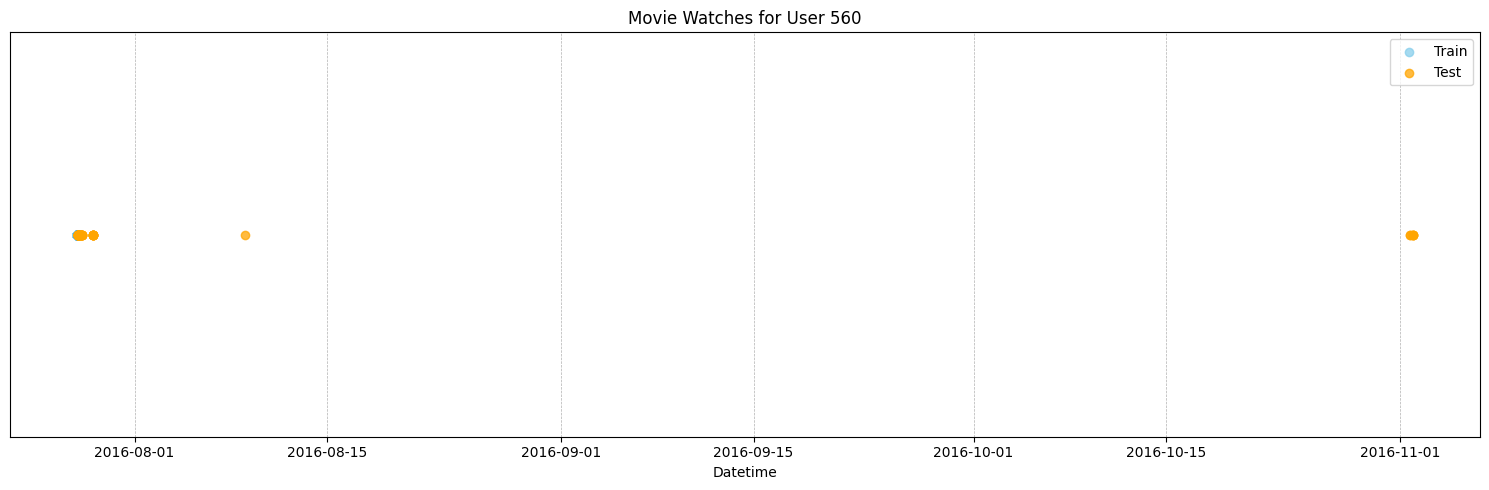

Both DataFrames have the same user IDs.
Train data saved to train_data.csv
Test data saved to test_data.csv


In [ ]:
# Step 3: Apply the temporal train-test split function
train_df, test_df = temporal_train_test_split(df_rating)
# Displaying the shapes of the outputs
print(" Full Data Shape:", df_rating.shape)
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

# Check for overlapping items between train and test sets
check_overlap(train_df, test_df)

# Visualize user interactions
visualize_user_exact_interaction(train_df, test_df)

# from now_on we will work only with train_df
df_rating = train_df.copy()


# Extract unique user IDs from both DataFrames
train_user_ids = set(train_df['userId'].unique())
test_user_ids = set(test_df['userId'].unique())

# Check if the user IDs are the same in both DataFrames
same_user_ids = train_user_ids == test_user_ids

# Print the result
if same_user_ids:
    print("Both DataFrames have the same user IDs.")
else:
    print("The DataFrames have different user IDs.")


# Specify the file paths for the train and test DataFrames
train_file_path = 'train_data.csv'
test_file_path = 'test_data.csv'

# Save the train and test DataFrames to CSV files
train_df.to_csv(train_file_path, index=False)
test_df.to_csv(test_file_path, index=False)

print(f"Train data saved to {train_file_path}")
print(f"Test data saved to {test_file_path}")


In [ ]:
import pandas as pd

# Calculate #Interactions: Count of items each user interacted with
user_interactions = train_df.groupby('userId').size().reset_index(name='num_interactions')

# Calculate User Activity: Average interaction frequency based on timestamps
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='s')
user_activity = train_df.groupby('userId').agg(
    activity_frequency=('timestamp', lambda x: (x.max() - x.min()).days / len(x) if len(x) > 1 else 0)
).reset_index()

# Calculate User Mean Rating: Average rating given by each user
user_mean_rating = train_df.groupby('userId')['rating'].mean().reset_index(name='mean_rating')

# Calculate User Mainstreamness: Compare user's average rating per item to global average rating for the item
global_item_mean = train_df.groupby('itemId')['rating'].mean().rename('global_item_mean')
train_df = train_df.merge(global_item_mean, on='itemId', suffixes=('', '_global'))
train_df['mainstreamness_diff'] = abs(train_df['rating'] - train_df['global_item_mean'])
user_mainstreamness = train_df.groupby('userId')['mainstreamness_diff'].mean().reset_index(name='mainstreamness')
eamness = train_df.groupby('userId')['mainstreamness_diff'].mean().reset_index(name='mainstreamness')

# Merge all calculated statistics into one dataframe
user_stats = user_interactions.merge(user_activity, on='userId')
user_stats = user_stats.merge(user_mean_rating, on='userId')
user_stats = user_stats.merge(user_mainstreamness, on='userId')

display(user_stats)

,userId,num_interactions,activity_frequency,mean_rating,mainstreamness
0,1,164,0.000000,4.408537,0.907014
1,2,23,0.000000,3.847826,0.513185
2,3,31,0.000000,2.935484,1.668526
3,4,146,3.308219,3.643836,1.038700
4,5,35,0.000000,3.600000,0.667279
...,...,...,...,...,...
605,606,536,0.095149,3.746269,0.457491
606,607,140,0.135714,3.857143,0.847042
607,608,562,0.005338,3.122776,0.729380
608,609,29,0.000000,3.275862,0.391237


In [ ]:
# Part 1: User Embedding Computation and Extraction

import pandas as pd
import numpy as np
import ast
import datetime
import pickle

# Finding the column that contains the word 'embedding' in the name
embedding_array = [col for col in df_items_filtered.columns if 'embedding' in col.lower()][0]
print(f'embedding_array = {embedding_array}')
# combined text: Original data from which embeddings are extracted (genre, title, tag)
# Gen text from which embeddings are extracted (genre, title, Gen tag)

# Function to convert string embeddings back to numpy arrays
def parse_embedding(embedding_str):
    """
    Parse a string representation of an embedding back into a numpy array.

    Args:
        embedding_str (str): String representation of an embedding.

    Returns:
        np.array: Numpy array of the embedding.
    """
    embedding_list = ast.literal_eval(embedding_str.strip())
    return np.array(embedding_list)

# Parse embeddings in df_items_filtered
df_items_filtered['embedding_array'] = df_items_filtered[embedding_array].apply(parse_embedding)


# Function to compute weights with a temporal decay strategy
def compute_weights_partitioned(user_items, lambda_decay=0.001, power_factor=1.0):
    """
    Compute user embedding by applying a temporal decay to item interactions.

    Args:
        user_items (pd.DataFrame): User's item interaction data.
        lambda_decay (float): Decay constant to control temporal effect.
        power_factor (float): Power factor to increase the importance of temporal weights.

    Returns:
        np.array: Weighted average embedding for the user.
    """
    # Sort items by timestamp in descending order (most recent first)
    user_items_sorted = user_items.sort_values(by='timestamp', ascending=False)

    # Get the maximum timestamp for this user
    max_timestamp = user_items_sorted['timestamp'].max()

    # Define the exponential decay function
    def temporal_decay(timestamp):
        time_diff = (max_timestamp - timestamp).total_seconds()
        return np.exp(-lambda_decay * time_diff)

    # Apply temporal decay to each item's timestamp
    user_items_sorted['temporal_weight'] = user_items_sorted['timestamp'].apply(temporal_decay)

    # Apply power factor to temporal weights
    user_items_sorted['temporal_weight'] = user_items_sorted['temporal_weight'] ** power_factor

    # Compute weighted average embedding with temporal weights
    def weighted_average_embedding(items):
        if items.empty:
            return np.zeros(user_items_sorted['embedding_array'].iloc[0].shape)

        embeddings = np.vstack(items['embedding_array'].values)
        ratings = items['rating'].values.reshape(-1, 1)
        temporal_weights = items['temporal_weight'].values.reshape(-1, 1)

        weights = ratings * temporal_weights

        if np.sum(weights) == 0:
            return np.zeros(embeddings.shape[1])

        weighted_embeddings = embeddings * weights
        return np.sum(weighted_embeddings, axis=0) / np.sum(weights)

    # Compute the final embedding using the weighted average
    user_embedding = weighted_average_embedding(user_items_sorted)
    return user_embedding

# Function to compute user embedding with safe division
def compute_user_embedding(user_items, weights):
    """
    Compute user embedding based on provided weights, ensuring no division by zero.

    Args:
        user_items (pd.DataFrame): User's item interaction data.
        weights (list or np.array): Weights for each interaction.

    Returns:
        np.array: Weighted average embedding for the user.
    """
    embeddings = np.vstack(user_items['embedding_array'].values)
    weights = np.array(weights).reshape(-1, 1)

    if np.sum(weights) == 0:
        print(f"Warning: Sum of weights is zero for user {user_items['userId'].iloc[0]}")
        user_embedding = np.zeros(embeddings.shape[1])
    else:
        weighted_embeddings = embeddings * weights
        user_embedding = np.sum(weighted_embeddings, axis=0) / np.sum(weights)

    return user_embedding

# Compute user embeddings for all users
user_ids = df_rating['userId'].unique()
user_embeddings = {}

lambda_decay = 0.01
power_factor = 1.2

for user_id in user_ids:
    # Get user ratings
    user_ratings = df_rating[df_rating['userId'] == user_id]

    # Merge user ratings with item embeddings
    user_items = pd.merge(
        user_ratings[['itemId', 'rating', 'timestamp']],
        df_items_filtered[['itemId', 'embedding_array']],
        on='itemId',
        how='inner'
    )

    if not user_items.empty:
        # Method 1: Weighted by Rating (Normal Average)
        weights_rating = user_items['rating'].values
        user_embedding_rating = compute_user_embedding(user_items, weights_rating)

        # Method 2: Weighted by Decay Strategy
        user_embedding_decay = compute_weights_partitioned(user_items, lambda_decay=lambda_decay, power_factor=power_factor)

        # Save embeddings
        user_embeddings[user_id] = {
            'embedding_rating': user_embedding_rating,
            'embedding_decay': user_embedding_decay
        }

# Save user embeddings to disk
with open(f'User_embedding_{file}_lamb{lambda_decay}_pow_{power_factor}.pkl', 'wb') as f:
    pickle.dump(user_embeddings, f)

print("User embeddings computed and saved successfully.")

embedding_array = embedding_tag_global_k5_text-embedding-ada-002
User embeddings computed and saved successfully.


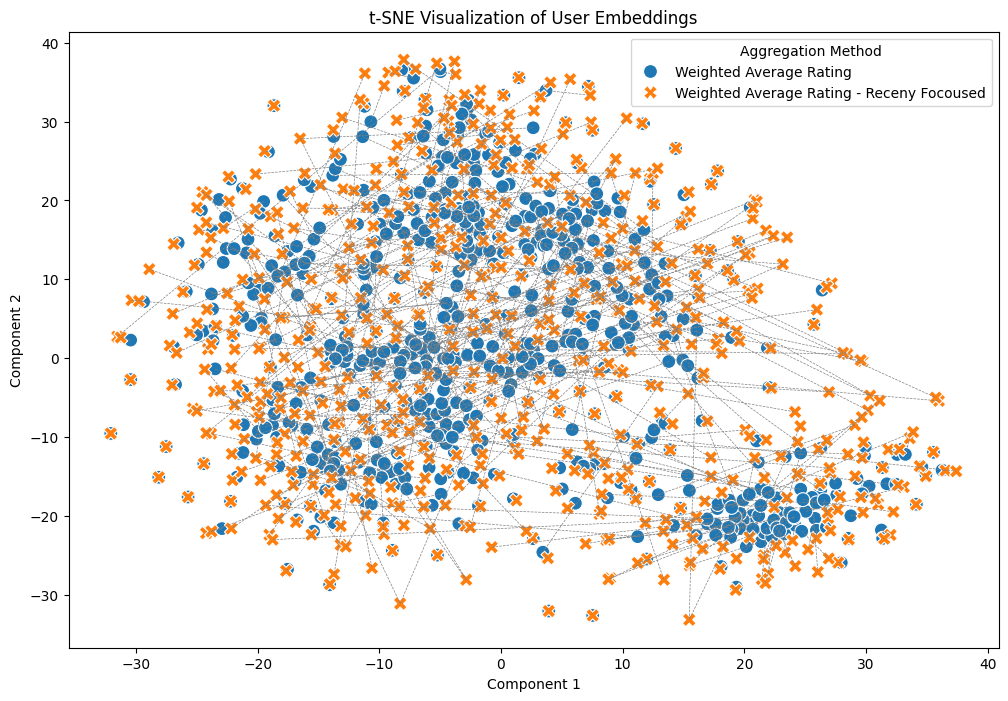

In [ ]:
 # Part 2: Visualization of User Embeddings using t-SNE

import numpy as np
import pandas as pd
import pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Load user embeddings
with open(f'User_embedding_{file}_lamb{lambda_decay}_pow_{power_factor}.pkl', 'rb') as f:
    user_embeddings = pickle.load(f)

# Prepare data for visualization
user_ids = list(user_embeddings.keys())

# Extract embeddings for both methods
embeddings_rating = np.array([user_embeddings[user_id]['embedding_rating'] for user_id in user_ids])
embeddings_decay = np.array([user_embeddings[user_id]['embedding_decay'] for user_id in user_ids])

# Combine embeddings into a single array
embeddings_combined = np.vstack((embeddings_rating, embeddings_decay))

# Create labels to distinguish between the two methods
labels = ['Weighted Average Rating'] * len(user_ids) + ['Weighted Average Rating - Receny Focoused'] * len(user_ids)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='random')
embeddings_2d = tsne.fit_transform(embeddings_combined)

# Create a DataFrame for plotting
df_visualization = pd.DataFrame({
    'UserID': user_ids * 2,
    'X': embeddings_2d[:, 0],
    'Y': embeddings_2d[:, 1],
    'Method': labels
})

# Plot the embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_visualization, x='X', y='Y', hue='Method', style='Method', s=100)

# Optionally, connect the points for the same user
for user_id in user_ids:
    idx_rating = df_visualization[(df_visualization['UserID'] == user_id) & (df_visualization['Method'] == 'Weighted Average Rating')].index[0]
    idx_decay = df_visualization[(df_visualization['UserID'] == user_id) & (df_visualization['Method'] == 'Weighted Average Rating - Receny Focoused')].index[0]
    x_values = [df_visualization.loc[idx_rating, 'X'], df_visualization.loc[idx_decay, 'X']]
    y_values = [df_visualization.loc[idx_rating, 'Y'], df_visualization.loc[idx_decay, 'Y']]
    plt.plot(x_values, y_values, color='gray', linestyle='--', linewidth=0.5)

plt.title('t-SNE Visualization of User Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Aggregation Method')
plt.show()

## Test Faiis Library - KNN Dense Retrieval  

User embedding: [0.7 0.6 0.5]
Recommended items and their L2 distances:
Item ID: 2, L2 Distance: 0.0800
Item ID: 4, L2 Distance: 0.2000


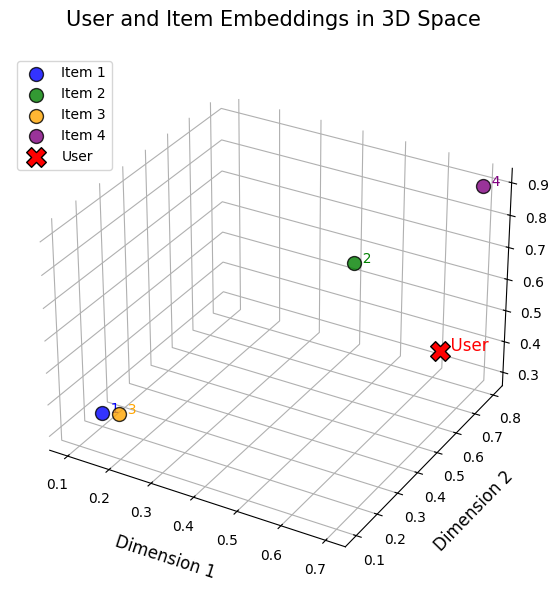

In [ ]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Toy example item embeddings (4 items with 3-dimensional embeddings)
item_embeddings = np.array([
    [0.1, 0.2, 0.3],
    [0.5, 0.6, 0.7],
    [0.2, 0.1, 0.4],
    [0.7, 0.8, 0.9]
], dtype='float32')

# Corresponding item IDs
item_ids = np.array([1, 2, 3, 4])

# User embedding (3-dimensional vector)
user_embedding = np.array([0.7, 0.6, 0.5], dtype='float32')

# Create FAISS index and add item embeddings
embedding_dimension = item_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dimension)
index.add(item_embeddings)

# Map index positions to item IDs
id_map = np.array(item_ids)

# Get top 2 recommendations for the user
def get_recommendations_faiss(user_embedding, id_map, index, top_N=5):
    """
    Get top-N recommendations for a given user embedding using FAISS.

    Args:
        user_embedding (np.array): User embedding vector.
        id_map (np.array): Mapping of index positions to item IDs.
        index (faiss.IndexFlatL2): FAISS index with item embeddings.
        top_N (int): Number of recommendations to retrieve.

    Returns:
        np.array: Recommended item IDs.
        np.array: Distances of the recommended items.
    """
    user_embedding = np.array([user_embedding]).astype('float32')
    distances, indices = index.search(user_embedding, top_N)
    recommended_item_ids = id_map[indices[0]]
    return recommended_item_ids, distances[0]

# Get recommendations
top_N = 2
recommended_item_ids, distances = get_recommendations_faiss(user_embedding, id_map, index, top_N)

# Print recommended item IDs and their similarity (distance) values
print(f"User embedding: {user_embedding}")
print("Recommended items and their L2 distances:")
for i in range(top_N):
    print(f"Item ID: {recommended_item_ids[i]}, L2 Distance: {distances[i]:.4f}")

# Plotting the user embedding and item embeddings for visualization
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot item embeddings
colors = ['b', 'g', 'orange', 'purple']
for idx, embedding in enumerate(item_embeddings):
    ax.scatter(embedding[0], embedding[1], embedding[2], c=colors[idx], label=f'Item {item_ids[idx]}', s=100, edgecolor='k', alpha=0.8)
    ax.text(embedding[0], embedding[1], embedding[2], f'  {item_ids[idx]}', size=10, color=colors[idx])

# Plot user embedding
ax.scatter(user_embedding[0], user_embedding[1], user_embedding[2], c='r', label='User', s=200, marker='X', edgecolor='k')
ax.text(user_embedding[0], user_embedding[1], user_embedding[2], '  User', size=12, color='r')

# Plotting details
ax.set_xlabel('Dimension 1', fontsize=12, labelpad=10)
ax.set_ylabel('Dimension 2', fontsize=12, labelpad=10)
ax.set_zlabel('Dimension 3', fontsize=12, labelpad=10)
ax.set_title('User and Item Embeddings in 3D Space', fontsize=15, pad=20)

# Improve the visual appearance
ax.grid(True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# Test FaiS Library on Single User from Dataset (for recommednation)


Retrieved Candidates for User 3:
      itemId                                  title  \
47      1077                         Sleeper (1973)   
110      332           Village of the Damned (1995)   
195     3113                     End of Days (1999)   
354     1240                 Terminator, The (1984)   
384    52281                      Grindhouse (2007)   
390      799                Frighteners, The (1996)   
526     3686                      Flatliners (1990)   
571     1924         Plan 9 from Outer Space (1959)   
779      198                    Strange Days (1995)   
798     2600                        eXistenZ (1999)   
876     2021                            Dune (1984)   
952     6774                      Videodrome (1983)   
1008    5040             Conan the Destroyer (1984)   
1010     610                     Heavy Metal (1981)   
1043    1591                           Spawn (1997)   
1062    7001  Invasion of the Body Snatchers (1978)   
1100     426                  B

<ipython-input-15-681981f3e9e4>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_train_data['datetime'] = pd.to_datetime(user_train_data['timestamp'], unit='s')


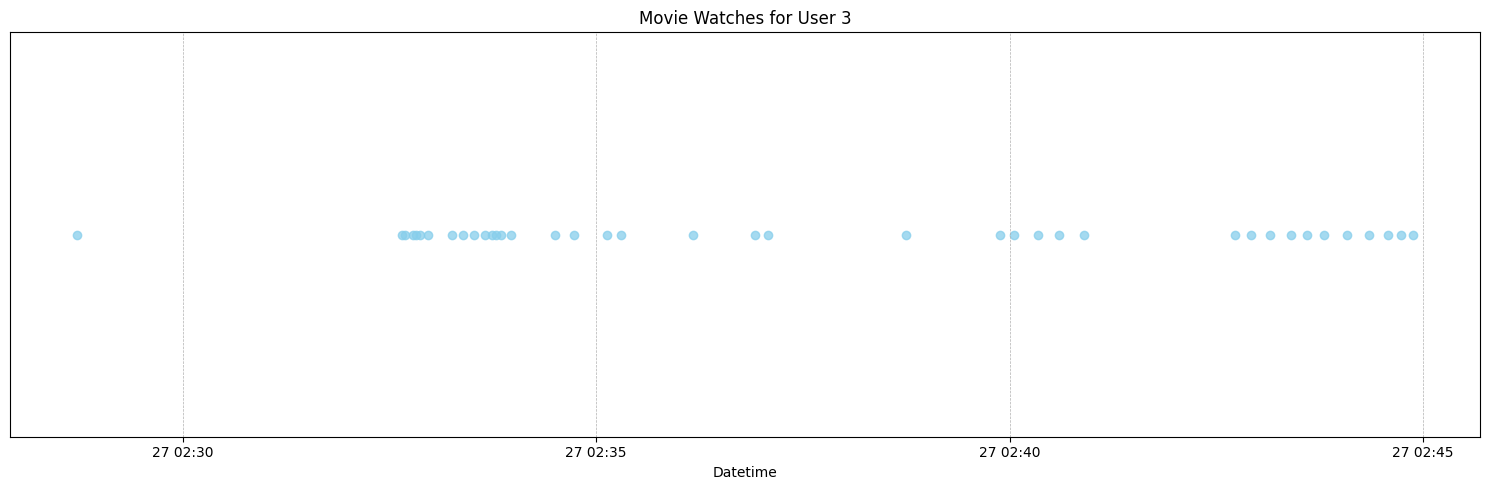

In [ ]:
import pandas as pd
import numpy as np
import faiss
import pickle
import matplotlib.pyplot as plt

# Load item embeddings
df_items_filtered['embedding_array'] = df_items_filtered[embedding_array].apply(parse_embedding)
item_embeddings = np.vstack(df_items_filtered['embedding_array'].tolist())
item_ids = df_items_filtered['itemId'].values

# Load user embeddings with temporal decay
with open(f'User_embedding_{file}_lamb{lambda_decay}_pow_{power_factor}.pkl', 'rb') as f:
    user_embeddings = pickle.load(f)

# Filter out items the user has already interacted with
def filter_items(user_id, item_ids, df_ratings):
    user_rated_item_ids = df_ratings[df_ratings['userId'] == user_id]['itemId'].values
    return item_ids[~np.isin(item_ids, user_rated_item_ids)]

# Step 1: Filter items before building FAISS index
user_id = 3
filtered_item_ids = filter_items(user_id, item_ids, df_ratings)
filtered_item_embeddings = item_embeddings[np.isin(item_ids, filtered_item_ids)]

# Step 2: Build FAISS index for the filtered catalog
embedding_dimension = filtered_item_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dimension)

# Add filtered item embeddings to the index
index.add(filtered_item_embeddings)

# Map index positions to filtered item IDs
id_map = np.array(filtered_item_ids)

# Function: Embedding Retrieval
def embedding_retrieval(user_embedding: np.ndarray, id_map: np.ndarray, index: faiss.IndexFlatL2, n: int) -> np.ndarray:
    """
    Retrieve n candidate items for a given user embedding using FAISS.

    Parameters:
        user_embedding (np.ndarray): User embedding to retrieve similar items.
        id_map (np.ndarray): Array mapping FAISS index positions to item IDs.
        index (faiss.IndexFlatL2): FAISS index containing item embeddings.
        n (int): Number of candidate items to retrieve.

    Returns:
        np.ndarray: Array of candidate item IDs.
    """
    distances, indices = index.search(user_embedding.reshape(1, -1), n)
    return id_map[indices[0]]

# Step 3: Main Function to Execute Retrieval
n_candidates = 50  # Number of candidates to retrieve

# Get user embedding with temporal decay
user_embedding_decay = user_embeddings[user_id]['embedding_decay']

# Retrieve n candidates
candidate_item_ids = embedding_retrieval(user_embedding_decay.astype('float32'), id_map, index, n_candidates)

# Display retrieved candidates
retrieved_items = df_items_filtered[df_items_filtered['itemId'].isin(candidate_item_ids)]
print(f"\nRetrieved Candidates for User {user_id}:")
print(retrieved_items[['itemId', 'title', 'genres']])

# Visualization of User Interactions
# Visualize the exact timestamps of movies watched for the user
user_train_data = df_ratings[df_ratings['userId'] == user_id]
user_train_data['datetime'] = pd.to_datetime(user_train_data['timestamp'], unit='s')

# Plotting
plt.figure(figsize=(15, 5))
plt.scatter(user_train_data['datetime'], [1]*len(user_train_data), color='skyblue', alpha=0.75)
plt.title(f'Movie Watches for User {user_id}')
plt.xlabel('Datetime')
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Test Faiss Library for Recomemdnation on all Users

In [ ]:
import pandas as pd
import numpy as np
import faiss
import pickle

df_train = pd.read_csv("drive_folder/" + 'train_data_enriched_dataset_ml-latest-small_filtering_min_20_max_100.csv')


# Load item embeddings
df_items_filtered['embedding_array'] = df_items_filtered[embedding_array].apply(parse_embedding)
item_embeddings = np.vstack(df_items_filtered['embedding_array'].tolist())
item_ids = df_items_filtered['itemId'].values

# Load user embeddings with both embedding types (embedding_rating and embedding_decay)
with open(f'User_embedding_{file}_lamb{lambda_decay}_pow_{power_factor}.pkl', 'rb') as f:
    user_embeddings = pickle.load(f)

# Function: Get top-n recommendations for a single user
def get_recommendations(user_id, user_embedding, item_ids, item_embeddings, df_ratings, n_candidates=50):
    # Filter out items the user has already interacted with
    user_rated_item_ids = df_ratings[df_ratings['userId'] == user_id]['itemId'].values
    mask = ~np.isin(item_ids, user_rated_item_ids)
    filtered_item_ids = item_ids[mask]
    #filtered_item_ids = item_ids
    filtered_item_embeddings = item_embeddings[mask]
    #filtered_item_embeddings = item_embeddings

    # Build FAISS index
    index = faiss.IndexFlatL2(filtered_item_embeddings.shape[1])
    index.add(filtered_item_embeddings.astype('float32'))

    # Retrieve top n items
    distances, indices = index.search(user_embedding.reshape(1, -1).astype('float32'), n_candidates)
    candidate_item_ids = filtered_item_ids[indices[0]]
    return candidate_item_ids

# Initialize list to store results
results = []

# Loop through each user in the test_df and retrieve the top 50 items for both embedding types
# note that train and test df have teh smae user ids
for user_id in test_df['userId'].unique():
    # Get both embedding types for the user
    embeddings = {
        'embedding_rating': user_embeddings[user_id]['embedding_rating'],
        'embedding_decay': user_embeddings[user_id]['embedding_decay']
    }

    # Retrieve top 50 items for each embedding type
    for embedding_type, user_embedding in embeddings.items():
        candidate_item_ids = get_recommendations(
            user_id, user_embedding, item_ids, item_embeddings, df_train, n_candidates= 25
        )

        # Retrieve the corresponding metadata
        retrieved_items = df_items_filtered[df_items_filtered['itemId'].isin(candidate_item_ids)].copy()
        retrieved_items.loc[:, 'userId'] = user_id  # Using loc to avoid SettingWithCopyWarning
        retrieved_items.loc[:, 'embedding_type'] = embedding_type
        results.append(retrieved_items[['userId', 'itemId', 'title', 'genres', 'embedding_type']])

# Concatenate all results into a single DataFrame
final_Rec_results_df = pd.concat(results, ignore_index=True)

# Split results into separate DataFrames based on embedding type
final_Rec_results_rating_df = final_Rec_results_df[final_Rec_results_df['embedding_type'] == 'embedding_rating'].drop(columns='embedding_type')
final_Rec_results_decay_df = final_Rec_results_df[final_Rec_results_df['embedding_type'] == 'embedding_decay'].drop(columns='embedding_type')


In [ ]:
final_Rec_results_rating_df

,userId,itemId,title,genres
0,1,3997,Dungeons & Dragons (2000),Action|Adventure|Comedy|Fantasy
1,1,1894,Six Days Seven Nights (1998),Adventure|Comedy|Romance
2,1,1918,Lethal Weapon 4 (1998),Action|Comedy|Crime|Thriller
3,1,198,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
4,1,2021,Dune (1984),Adventure|Sci-Fi
...,...,...,...,...
30470,610,533,"Shadow, The (1994)",Action|Adventure|Fantasy|Mystery
30471,610,63062,Changeling (2008),Crime|Drama|Mystery
30472,610,61248,Death Race (2008),Action|Adventure|Sci-Fi|Thriller
30473,610,1479,"Saint, The (1997)",Action|Romance|Sci-Fi|Thriller


In [ ]:
final_Rec_results_decay_df

,userId,itemId,title,genres
25,1,3029,Nighthawks (1981),Action|Drama
26,1,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller
27,1,52281,Grindhouse (2007),Action|Crime|Horror|Sci-Fi|Thriller
28,1,1483,Crash (1996),Drama|Thriller
29,1,55765,American Gangster (2007),Crime|Drama|Thriller
...,...,...,...,...
30495,610,3682,Magnum Force (1973),Action|Crime|Drama|Thriller
30496,610,533,"Shadow, The (1994)",Action|Adventure|Fantasy|Mystery
30497,610,58803,21 (2008),Crime|Drama|Romance|Thriller
30498,610,5312,Murder by Numbers (2002),Crime|Thriller


In [ ]:
import pandas as pd

# Load the test dataset
df_test = pd.read_csv("drive_folder/" + 'test_data_enriched_dataset_ml-latest-small_filtering_min_20_max_100.csv')

# Processing the first dataframe to create lists of recommended itemIds per user (Rating-based)
rec_item_Rating = final_Rec_results_rating_df.groupby('userId')['itemId'].apply(list).reset_index(name='rec_item_Rating')

# Processing the second dataframe to create lists of recommended itemIds per user (Decay-based)
rec_items_Decay = final_Rec_results_decay_df.groupby('userId')['itemId'].apply(list).reset_index(name='rec_items_Decay')

# Processing the ground truth dataframe to create lists of ground truth itemIds per user
gt_items = df_test.groupby('userId')['itemId'].apply(list).reset_index(name='gt_items')

# Merging all three lists into the required format
result_df = pd.merge(gt_items, rec_item_Rating, on='userId')
result_df = pd.merge(result_df, rec_items_Decay, on='userId')

# Displaying the result in the specified format
result_df = result_df[['userId', 'gt_items', 'rec_item_Rating', 'rec_items_Decay']]


In [ ]:
result_df = pd.merge(result_df, user_stats, on='userId')

# Arrange columns as specified
result_df = result_df[['userId', 'num_interactions', 'activity_frequency', 'mean_rating', 'mainstreamness',
                       'gt_items', 'rec_item_Rating', 'rec_items_Decay']]

# Display the final result
result_df.head()

,userId,num_interactions,activity_frequency,mean_rating,mainstreamness,gt_items,rec_item_Rating,rec_items_Decay
0,1,164,0.000000,4.408537,0.907014,"[1219, 1348, 2644, 1258, 1278, 2459, 2648, 271...","[3997, 1894, 1918, 198, 2021, 2968, 3259, 610,...","[3029, 145, 52281, 1483, 55765, 3741, 288, 325..."
1,2,23,0.000000,3.847826,0.513185,"[80906, 89774, 1704, 122882, 114060, 80489]","[80489, 59369, 53519, 106916, 55765, 104879, 6...","[6214, 89904, 174055, 68554, 60684, 4161, 1351..."
2,3,31,0.000000,2.935484,1.668526,"[6238, 1124, 688, 3949, 2090, 527, 5048, 2424]","[1214, 3981, 1240, 52281, 1924, 7743, 198, 202...","[1077, 1240, 52281, 799, 1924, 198, 6774, 610,..."
3,4,146,3.308219,3.643836,1.038700,"[4033, 3967, 4027, 3408, 4014, 3897, 3317, 113...","[1244, 6708, 2580, 205, 1894, 49286, 1918, 911...","[7090, 1263, 6618, 3785, 8983, 59784, 708, 872..."
4,5,35,0.000000,3.600000,0.667279,"[410, 596, 266, 290, 475, 534, 247, 300, 474]","[1835, 1894, 1918, 911, 32587, 198, 3259, 3358...","[1244, 1835, 6708, 259, 1894, 198, 1958, 492, ..."


In [ ]:
result_df.to_csv('recResults_' + file, index=False)

In [ ]:
result_df

,userId,num_interactions,activity_frequency,mean_rating,mainstreamness,gt_items,rec_item_Rating,rec_items_Decay
0,1,164,0.000000,4.408537,0.907014,"[1219, 1348, 2644, 1258, 1278, 2459, 2648, 271...","[3997, 1894, 1918, 198, 2021, 2968, 3259, 610,...","[3029, 145, 52281, 1483, 55765, 3741, 288, 325..."
1,2,23,0.000000,3.847826,0.513185,"[80906, 89774, 1704, 122882, 114060, 80489]","[80489, 59369, 53519, 106916, 55765, 104879, 6...","[6214, 89904, 174055, 68554, 60684, 4161, 1351..."
2,3,31,0.000000,2.935484,1.668526,"[6238, 1124, 688, 3949, 2090, 527, 5048, 2424]","[1214, 3981, 1240, 52281, 1924, 7743, 198, 202...","[1077, 1240, 52281, 799, 1924, 198, 6774, 610,..."
3,4,146,3.308219,3.643836,1.038700,"[4033, 3967, 4027, 3408, 4014, 3897, 3317, 113...","[1244, 6708, 2580, 205, 1894, 49286, 1918, 911...","[7090, 1263, 6618, 3785, 8983, 59784, 708, 872..."
4,5,35,0.000000,3.600000,0.667279,"[410, 596, 266, 290, 475, 534, 247, 300, 474]","[1835, 1894, 1918, 911, 32587, 198, 3259, 3358...","[1244, 1835, 6708, 259, 1894, 198, 1958, 492, ..."
...,...,...,...,...,...,...,...,...
605,606,536,0.095149,3.746269,0.457491,"[7099, 3160, 3426, 1729, 8128, 920, 8622, 1246...","[6708, 193, 205, 1894, 49286, 3358, 3730, 5902...","[49649, 4467, 162578, 1894, 59501, 2116, 54259..."
606,607,140,0.135714,3.857143,0.847042,"[1249, 593, 1, 949, 1625, 3347, 919, 1023, 107...","[3113, 52281, 799, 1483, 32587, 198, 170, 1591...","[4901, 1483, 3783, 55290, 2443, 547, 4465, 509..."
607,608,562,0.005338,3.122776,0.729380,"[2676, 5308, 5219, 4054, 93, 3316, 3355, 1772,...","[3997, 4232, 52281, 799, 6550, 1894, 3784, 198...","[4232, 3113, 68554, 52281, 799, 6550, 2004, 37..."
608,609,29,0.000000,3.275862,0.391237,"[828, 1059, 1150, 650, 833, 892, 1056, 1161]","[1240, 1918, 32587, 198, 55854, 3259, 170, 335...","[1483, 1918, 198, 55854, 3358, 507, 23, 1653, ..."


In [ ]:



import ast

# Function to convert values to lists of integers if needed
def ensure_list_of_integers(value):
    if isinstance(value, str):  # If the value is a string, interpret it as a list
        return list(map(int, ast.literal_eval(value)))
    elif isinstance(value, list):  # If already a list, ensure all elements are integers
        return list(map(int, value))
    else:
        return []

# Apply the function to both recItemId and gtItemId columns
result_df['recItemId'] = result_df['recItemId'].apply(ensure_list_of_integers)
result_df['gtItemId'] = result_df['gtItemId'].apply(ensure_list_of_integers)

# Define a function to calculate recall and precision for each row, with debugging
def calculate_recall_precision(row):
    rec_items_set = set(row['recItemId'])
    gt_items_set = set(row['gtItemId'])

    # Debugging output to verify content
    print("rec_items_set:", rec_items_set)
    print("gt_items_set:", gt_items_set)
    print("Intersection:", rec_items_set.intersection(gt_items_set))

    # Calculate recall
    recall = len(rec_items_set.intersection(gt_items_set)) / len(gt_items_set) if gt_items_set else 0
    # Calculate precision
    precision = len(rec_items_set.intersection(gt_items_set)) / len(rec_items_set) if rec_items_set else 0

    return pd.Series([recall, precision])

# Apply the function to each row in the dataframe
result_df[['recall', 'precision']] = result_df.apply(calculate_recall_precision, axis=1)

# Display the updated dataframe with recall and precision columns
display(result_df)

# Calculate the average recall and precision across all users
average_recall = result_df['recall'].mean()
average_precision = result_df['precision'].mean()

print(f"Average Recall: {average_recall}")
print(f"Average Precision: {average_precision}")


# Export the results for each embedding type to separate CSV files
file1 = f'rec_items_RAG_retri_rating_' + file
result_df.to_csv(file1, index=False)

rec_items_set: {514, 1027, 517, 10, 1034, 1036, 533, 23, 1562, 2587, 1566, 544, 72226, 547, 4133, 3623, 553, 4654, 558, 5171, 1588, 3638, 1591, 52281, 2618, 2109, 2623, 4161, 6721, 1091, 1603, 69, 1095, 588, 1615, 2134, 86, 2140, 95, 610, 5220, 45672, 1129, 2153, 3699, 3701, 3702, 49272, 126, 2687, 4232, 2188, 653, 2701, 145, 1687, 151, 158, 671, 2720, 8865, 163, 2723, 165, 4265, 170, 4270, 2735, 688, 1200, 3763, 692, 3766, 72378, 1722, 1215, 704, 196, 198, 711, 3784, 3785, 61132, 205, 3791, 208, 54999, 34520, 4321, 1251, 2278, 743, 4327, 1772, 27373, 81132, 239, 5872, 2289, 1270, 4855, 4344, 761, 765, 256, 1287, 8972, 2318, 2321, 4887, 86298, 48412, 3358, 798, 3359, 3363, 4899, 3877, 1831, 2353, 1848, 315, 828, 2881, 6978, 2371, 2376, 81229, 849, 340, 1365, 32596, 1882, 1371, 2907, 1373, 1884, 3418, 1375, 1370, 353, 1894, 1385, 2409, 63853, 1391, 368, 6001, 4467, 1907, 3959, 376, 1911, 379, 1918, 3968, 1409, 5507, 5004, 6548, 6550, 2968, 2457, 8604, 2468, 5541, 4011, 2990, 434, 3508, 

,userId,recItemId,gtItemId,recall,precision
0,1,"[208, 2353, 1562, 3029, 466, 4133, 4232, 48412...","[1219, 1348, 2644, 1258, 1278, 2459, 2648, 271...",0.166667,0.035
1,2,"[367, 3717, 4239, 2353, 118700, 6214, 1729, 14...","[80906, 89774, 1704, 122882, 114060, 80489]",0.000000,0.000
2,3,"[5313, 2640, 208, 2046, 5944, 1676, 56145, 235...","[6238, 1124, 688, 3949, 2090, 527, 5048, 2424]",0.000000,0.000
3,4,"[367, 87413, 3257, 2389, 1729, 1244, 2718, 102...","[4033, 3967, 4027, 3408, 4014, 3897, 3317, 113...",0.162162,0.030
4,5,"[87413, 2353, 3257, 1562, 118700, 2389, 1729, ...","[410, 596, 266, 290, 475, 534, 247, 300, 474]",0.111111,0.005
...,...,...,...,...,...
605,606,"[87413, 118700, 2406, 2718, 102, 27, 5970, 415...","[7099, 3160, 3426, 1729, 8128, 920, 8622, 1246...",0.089552,0.060
606,607,"[367, 3238, 648, 786, 5944, 1676, 2353, 1459, ...","[1249, 593, 1, 949, 1625, 3347, 919, 1023, 107...",0.057143,0.010
607,608,"[786, 1459, 2389, 2718, 102, 4232, 415, 48412,...","[2676, 5308, 5219, 4054, 93, 3316, 3355, 1772,...",0.191489,0.135
608,609,"[367, 3238, 648, 5944, 1676, 2353, 3257, 1459,...","[828, 1059, 1150, 650, 833, 892, 1056, 1161]",0.125000,0.005


Average Recall: 0.1773001137784029
Average Precision: 0.02


In [ ]:
import ast

df_test = pd.read_csv("drive_folder/" + 'test_data_enriched_dataset_ml-latest-small_filtering_min_20_max_100.csv')
# Processing the first dataframe to create lists of itemIds per user
rec_items = final_Rec_results_decay_df.groupby('userId')['itemId'].apply(list).reset_index(name='recItemId')
# Processing the second dataframe to create lists of ground truth itemIds per user
gt_items = df_test.groupby('userId')['itemId'].apply(list).reset_index(name='gtItemId')
# Merging both lists into the required format
result_df = pd.merge(rec_items, gt_items, on='userId')


import ast

# Function to convert values to lists of integers if needed
def ensure_list_of_integers(value):
    if isinstance(value, str):  # If the value is a string, interpret it as a list
        return list(map(int, ast.literal_eval(value)))
    elif isinstance(value, list):  # If already a list, ensure all elements are integers
        return list(map(int, value))
    else:
        return []

# Apply the function to both recItemId and gtItemId columns
result_df['recItemId'] = result_df['recItemId'].apply(ensure_list_of_integers)
result_df['gtItemId'] = result_df['gtItemId'].apply(ensure_list_of_integers)

# Define a function to calculate recall and precision for each row, with debugging
def calculate_recall_precision(row):
    rec_items_set = set(row['recItemId'])
    gt_items_set = set(row['gtItemId'])

    # Debugging output to verify content
    print("rec_items_set:", rec_items_set)
    print("gt_items_set:", gt_items_set)
    print("Intersection:", rec_items_set.intersection(gt_items_set))

    # Calculate recall
    recall = len(rec_items_set.intersection(gt_items_set)) / len(gt_items_set) if gt_items_set else 0
    # Calculate precision
    precision = len(rec_items_set.intersection(gt_items_set)) / len(rec_items_set) if rec_items_set else 0

    return pd.Series([recall, precision])

# Apply the function to each row in the dataframe
result_df[['recall', 'precision']] = result_df.apply(calculate_recall_precision, axis=1)

# Display the updated dataframe with recall and precision columns
display(result_df)

# Calculate the average recall and precision across all users
average_recall = result_df['recall'].mean()
average_precision = result_df['precision'].mean()

print(f"Average Recall: {average_recall}")
print(f"Average Precision: {average_precision}")


# Export the results for each embedding type to separate CSV files
file1 = f'rec_items_RAG_retri_decay_lambda_decay{lambda_decay}_power_factor{power_factor}' + file
result_df.to_csv(file1, index=False)

rec_items_set: {519, 1034, 55820, 1036, 14, 78349, 16, 2579, 23, 97306, 2587, 1056, 544, 3104, 2599, 3113, 42, 2605, 4654, 1589, 52281, 1597, 61, 64575, 2112, 88129, 68157, 1092, 6214, 1095, 130634, 79, 63062, 8798, 5220, 100, 64614, 4720, 113, 628, 1653, 2676, 640, 1673, 6796, 2188, 4239, 145, 3730, 5782, 1687, 3741, 159, 44191, 1701, 3238, 4262, 1704, 4265, 170, 165, 44199, 3246, 5294, 5810, 3763, 692, 694, 3256, 185, 72378, 31420, 7360, 1729, 193, 707, 198, 3783, 40148, 1748, 54999, 6874, 7387, 1754, 51935, 1248, 225, 6879, 3300, 2278, 233, 27373, 4848, 2289, 1266, 4855, 4344, 765, 1792, 4865, 5387, 60684, 7438, 53519, 2320, 4369, 786, 7445, 4887, 2840, 4889, 4378, 280, 2334, 802, 3363, 805, 2353, 315, 2881, 5956, 5959, 2376, 91976, 32587, 3915, 3409, 4946, 340, 1365, 51540, 3418, 1883, 1884, 1370, 51037, 353, 866, 4450, 1892, 37733, 1385, 8042, 69481, 3952, 115569, 1912, 376, 379, 3452, 1918, 382, 2433, 5507, 1411, 33166, 5009, 6548, 8604, 106916, 62374, 2986, 4011, 428, 4017, 434,

,userId,recItemId,gtItemId,recall,precision
0,1,"[3238, 786, 4239, 2353, 1459, 4865, 6214, 1729...","[1219, 1348, 2644, 1258, 1278, 2459, 2648, 271...",0.047619,0.010
1,2,"[367, 4239, 118700, 6214, 1729, 89904, 48412, ...","[80906, 89774, 1704, 122882, 114060, 80489]",0.000000,0.000
2,3,"[367, 5313, 2640, 208, 2046, 1676, 56145, 2353...","[6238, 1124, 688, 3949, 2090, 527, 5048, 2424]",0.000000,0.000
3,4,"[7090, 87413, 3597, 466, 5107, 89904, 48412, 4...","[4033, 3967, 4027, 3408, 4014, 3897, 3317, 113...",0.081081,0.015
4,5,"[87413, 3257, 118700, 2389, 1889, 1244, 2718, ...","[410, 596, 266, 290, 475, 534, 247, 300, 474]",0.111111,0.005
...,...,...,...,...,...
605,606,"[2640, 71745, 810, 8974, 2046, 65088, 4299, 15...","[7099, 3160, 3426, 1729, 8128, 920, 8622, 1246...",0.067164,0.045
606,607,"[786, 92509, 2389, 4441, 27, 5970, 89904, 3203...","[1249, 593, 1, 949, 1625, 3347, 919, 1023, 107...",0.114286,0.020
607,608,"[3717, 3597, 2389, 2718, 102, 4232, 415, 48412...","[2676, 5308, 5219, 4054, 93, 3316, 3355, 1772,...",0.163121,0.115
608,609,"[367, 3238, 87413, 2353, 3257, 1459, 4865, 156...","[828, 1059, 1150, 650, 833, 892, 1056, 1161]",0.125000,0.005


Average Recall: 0.19290674224842294
Average Precision: 0.02259016393442623
